In [1]:
import pandas as pd
import yaml
from pathlib import Path
from datetime import datetime

import numpy as np
import trackpy
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from confocal_microscopy.files import ims
from confocal_microscopy.tracking.utils import load_background
from confocal_microscopy.roi_tools import centerline as centerline_tools

from numpy import exp
from scipy.optimize import brentq

Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
def load_physical_data(image_path):
    metadata = ims.load_ims_metadata(Path(image_path))

    ## Get the image metadata
    image_size = ims.find_physical_image_size(metadata)[1:]
    image_shape = [int(metadata['CustomData']["Height"]), int(metadata['CustomData']["Width"])]
    pixel_size = np.round(np.array(image_size) / image_shape, 3)

    timestamps = [datetime.fromisoformat(metadata['TimeInfo'][f'TimePoint{i+1}']) for i in range(7000)]
    timestamps = [t - timestamps[0] for t in timestamps]
    timestamps = [(t.seconds + t.microseconds*1e-6) for t in timestamps]
    timestamps = np.linspace(0, timestamps[-1], len(timestamps))

    timestep = timestamps[-1]/len(timestamps)
    return timestep, pixel_size, image_shape

def load_roi(bg_path, roi_id):
    with open(bg_path.parent/f"{bg_path.stem}_vertices.json") as f:
        annotated_info = yaml.load(f, Loader=yaml.SafeLoader)

    roi = annotated_info['vertices'][roi_id]
    centerline = np.stack([annotated_info['centerlines'][roi_id]['x'], annotated_info['centerlines'][roi_id]['y']], axis=1)
    return roi, centerline

def load_position_data(image_path, min_track_length=5):
    position_data = pd.read_csv(image_path.parent / f"{image_path.stem}.csv").drop("frame.1", axis=1)
    position_data = trackpy.filter_stubs(position_data, min_track_length)
    position_data = position_data.drop("frame", axis=1).reset_index()
    return position_data

def get_distance_to_centerline_img(roi, centerline, pixel_size, image_shape):
    assert pixel_size[0] == pixel_size[1]
    pixel_size = pixel_size[0]
    nearest_centerline_indices = centerline_tools.find_all_nearest_centerline_indices_from_roi(
        roi,
        image_shape,
        centerline
    )
    nearest_centerline_direction = centerline_tools.find_nearest_centerline_direction(nearest_centerline_indices, centerline)

    return centerline_tools.find_distance_to_centerline_from_roi(roi, image_shape, centerline) * pixel_size

def get_velocity_data(position_data, pixel_size, timestep, distance_to_centerline_img):
    velocity_data = []
    for particle, particle_positions in position_data.groupby("particle"):
        particle_diff = particle_positions.diff()
        particle_positions['vx [µm/s]'] = pixel_size[0] * particle_diff['x'] / (particle_diff['frame'] * timestep)
        particle_positions['vy [µm/s]'] = pixel_size[1] * particle_diff['y'] / (particle_diff['frame'] * timestep)
        particle_positions["Distance to centerline [µm]"] = bilinear(
            distance_to_centerline_img,
            particle_positions["x"],
            particle_positions["y"],
        )
        velocity_data.append(particle_positions)

    velocity_data = pd.concat(velocity_data)
    velocity_data['v [µm/s]'] = np.sqrt(velocity_data['vx [µm/s]']**2 + velocity_data['vy [µm/s]']**2)
    return velocity_data

def load_all_rois(bg_path):
    roi_id = 0
    rois = []
    centerlines = []
    while True:
        try:
            roi, centerline = load_roi(bg_path, roi_id)
        except IndexError:
            break
        roi_id += 1
        rois.append(roi)
        centerlines.append(centerline)
    num_rois = roi_id
    roi_id = 0
    return rois, centerlines

def bilinear(img, x, y):
    floor_xy = img[np.floor(y).astype(int), np.floor(x).astype(int)]
    ceil_xy = img[np.ceil(y).astype(int), np.ceil(x).astype(int)]
    floor_x_ceil_y = img[np.floor(y).astype(int), np.floor(x).astype(int)]
    ceil_x_floor_y = img[np.ceil(y).astype(int), np.ceil(x).astype(int)]
    
    
    weight_x = x - np.floor(x)
    weight_y = y - np.floor(y)
    
    y_tmp_left = floor_x_ceil_y * weight_y + (1 - weight_y) * floor_xy
    y_tmp_right = ceil_xy * weight_y + (1 - weight_y) * ceil_x_floor_y
    return weight_x * y_tmp_right + (1 - weight_x) * y_tmp_left

def get_all_velocities(image_path, rois, centerlines, viscosity__Pa_s):
    timestep__s, pixel_size__µm, image_shape = load_physical_data(image_path)
    auto_positions = load_position_data(image_path, min_track_length=5)
    num_rois = len(rois)
    auto_velocities = []
    for roi_id in range(num_rois):
        distance_to_centerline__µm = get_distance_to_centerline_img(rois[roi_id], centerlines[roi_id], pixel_size__µm, image_shape)
        current_roi_velocities = get_velocity_data(auto_positions, pixel_size__µm, timestep__s, distance_to_centerline__µm)
        current_roi_velocities = current_roi_velocities.dropna()
        current_roi_velocities["ROI ID"] = roi_id
        maximum_radius = np.nanmax(distance_to_centerline__µm)
        current_roi_velocities["Max R [µm]"] = maximum_radius

        auto_velocities.append(current_roi_velocities)

    auto_velocities = pd.concat(auto_velocities)
    
    velocity__m_per_s = auto_velocities["v [µm/s]"] * 1e-6
    distance__m = auto_velocities["Distance to centerline [µm]"] * 1e-6
    max_distance__m = auto_velocities["Max R [µm]"] * 1e-6

    auto_velocities["Pressure drop (Lee) [Pa/µm]"] = (
        1e-6 * 4 * velocity__m_per_s * Lee_viscosity__Pa_s / ((max_distance__m)**2 - (distance__m)**2)
    )
    auto_velocities["Pressure drop (Pries) [Pa/µm]"] = (
        1e-6 * 4 * velocity__m_per_s * Pries_viscosity__Pa_s(max_distance__m*1e6) / ((max_distance__m)**2 - (distance__m)**2)
    )
    return auto_velocities

In [3]:
def hd_to_ht(hd, d):
    ht_per_hd = hd + (1 - hd)*(1 + 1.7*exp(-0.415*d) - 0.6*exp(-0.011*d))
    return hd*ht_per_hd

def _ht_to_hd(ht, d, a=0, b=1):
    return brentq(lambda x: hd_to_ht(x, d) - ht, a, b)

def ht_to_hd(ht, d, a=0, b=1):
    d = np.asarray(d)
    
    @np.vectorize
    def comp(d):
        return _ht_to_hd(ht, d, a, b)
    return comp(d)


def Pries_mu045(d):
    return 220*exp(-1.3*d) + 3.2 - 2.44*exp(-0.06*(d**0.645))

def Pries_C(d):
    denom = 1 + (10**(-11))*(d**(12))
    factor = 1 / denom
    
    return (0.8 + exp(-0.075*d)) * (-1 + factor) + factor

def Pries_mu_vitro__cPoise(hd, d):
    C = Pries_C(d)
    mu045 = Pries_mu045(d)
    
    nominator = (1 - hd)**C - 1
    denominator = (1 - 0.45)**C - 1
    factor = nominator / denominator
    
    return 1 + (mu045 - 1)*factor

def lee_mu__cPoise(ht):
    ht = ht*100
    return 0.0007*ht*ht + 0.0495*ht + 1.5077

In [4]:
image_parent = Path(
    "/media/yngve/TOSHIBA EXT (YNGVE)/fish_data/organised/7 DAY OLD Fish with tumors/Fish 1 complete/Cancer region/Cancer vessel 3/"
    #"/media/yngve/TOSHIBA EXT (YNGVE)/fish_data/organised/"
    #"7 DAY OLD Fish with tumors/"
    #"Fish 2/Tumor vessels/Cancer vessel 4/"
    #"Fish 6/Healthy caudal artery"
    #"artery/1000"
    #"Caudal artery/Caudal artery imaging 2"
)


bg_path = sorted(image_parent.glob("*Snap*.ims"))[0]

In [5]:
print("Vessel", image_parent)
print("BG", bg_path)

Vessel /media/yngve/TOSHIBA EXT (YNGVE)/fish_data/organised/7 DAY OLD Fish with tumors/Fish 1 complete/Cancer region/Cancer vessel 3
BG /media/yngve/TOSHIBA EXT (YNGVE)/fish_data/organised/7 DAY OLD Fish with tumors/Fish 1 complete/Cancer region/Cancer vessel 3/fast_2020-09-02_Snap_10.56.47_JFM9CC2.ims


In [6]:
image_parent = Path(image_parent)
bg_path = Path(bg_path)
bg_img = load_background(bg_path)
rois, centerlines = load_all_rois(bg_path)
water_viscosity__Pa_s = 0.6913 * 1e-3
ht = 0.35

def Pries_viscosity__Pa_s(r):
    return Pries_mu_vitro__cPoise(ht_to_hd(ht, 2*r), 2*r) / 1000

Lee_viscosity__Pa_s = lee_mu__cPoise(ht) / 1000

num_imgs = len(sorted(image_parent.glob("*red ch*.ims")))
auto_velocities = []
for i, image_path in enumerate(sorted(image_parent.glob("*red ch*.ims"))):
    frame = ims.load_video_stack(image_path, num_timesteps=1).squeeze()
    assert frame.shape == bg_img.shape
    print(f"{i+1} / {num_imgs}")
    curr_auto_velocities = get_all_velocities(image_path, rois, centerlines, Lee_viscosity__Pa_s)
    curr_auto_velocities["dataset_id"] = i
    curr_auto_velocities["file"] = str(image_path)
    curr_auto_velocities["filename"] = str(image_path.name)
    auto_velocities.append(curr_auto_velocities)
auto_velocities = pd.concat(auto_velocities)

1 / 2
2 / 2


## Compute median per particle

In [7]:
median_velocities = auto_velocities.groupby(["dataset_id", "ROI ID", "particle"]).median().reset_index()
#median_velocities = median_velocities[median_velocities["Pressure drop [Pa/µm]"] < median_velocities["Pressure drop [Pa/µm]"].mean()*20]

## Diagnostic plots

Text(0.5, 1.0, 'Background image and ROI(s)')

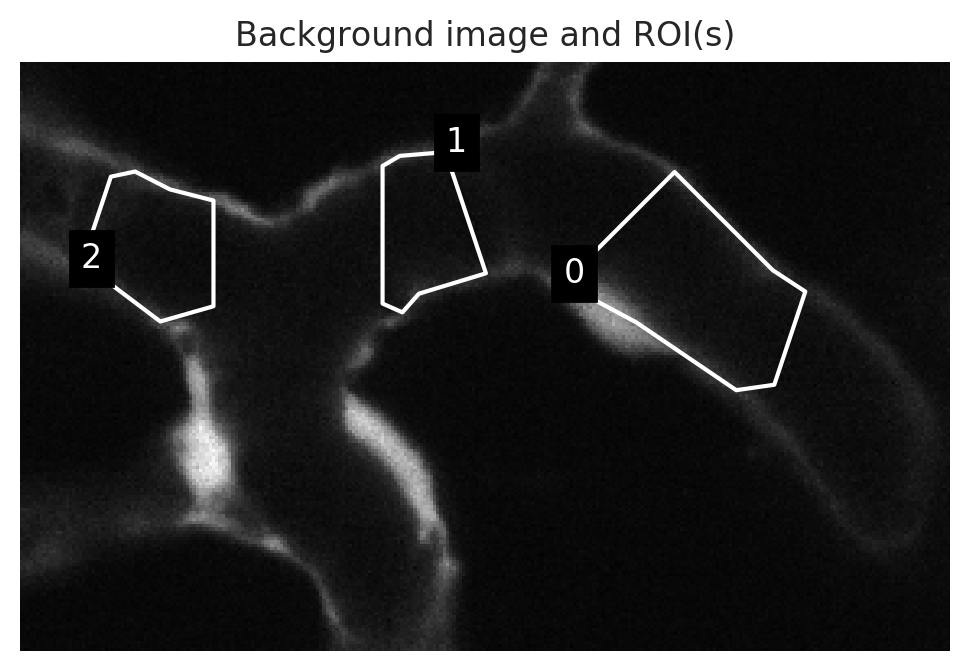

In [8]:
plt.figure(dpi=200)
plt.imshow(bg_img, cmap="gray")
for i, roi in enumerate(rois):
    plt.plot(roi['x'], roi['y'], color="white")
    plt.text(roi['x'][0], roi['y'][0], i, color="white", backgroundcolor="black")
plt.axis("off")
plt.title("Background image and ROI(s)")

Text(0.5, 1.0, 'Distribution of velocities')

<Figure size 1200x800 with 0 Axes>

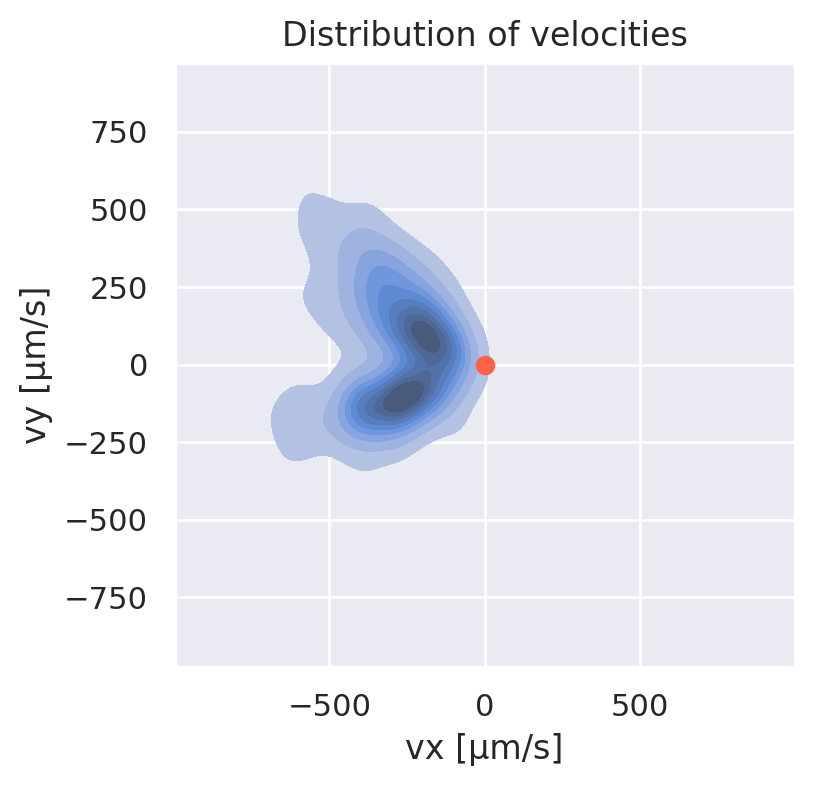

In [9]:
sns.set()
plt.figure(dpi=200)
#plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
sns.kdeplot(
    x=median_velocities["vx [µm/s]"],
    y=-median_velocities["vy [µm/s]"],
    fill=True,
    ax=ax
)
ax.scatter(0, 0, color='tomato')
ax.axis("equal")

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
min_val = min(ymin, xmin, -ymax, -xmax)
max_val = -min_val
ax.set_ylim(min_val, max_val)
ax.set_xlim(min_val, max_val)
ax.set_title("Distribution of velocities")

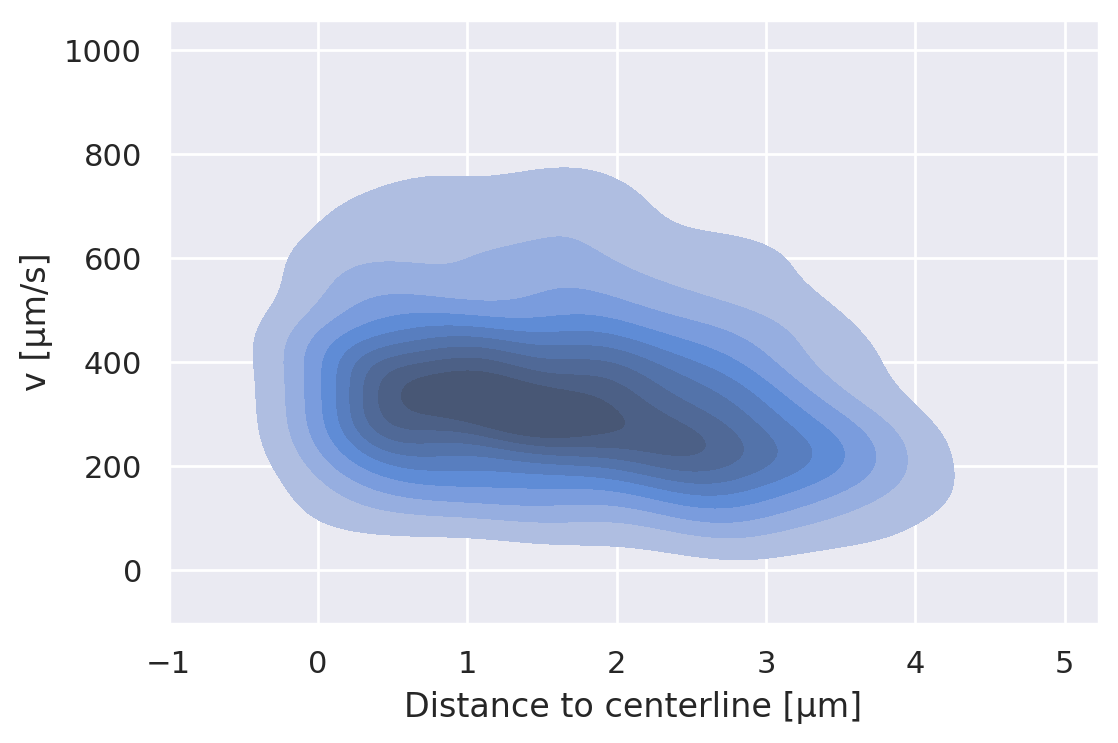

In [10]:
plt.figure(dpi=200)
sns.kdeplot(
    x=median_velocities["Distance to centerline [µm]"],
    y=median_velocities["v [µm/s]"],
    fill=True,
)

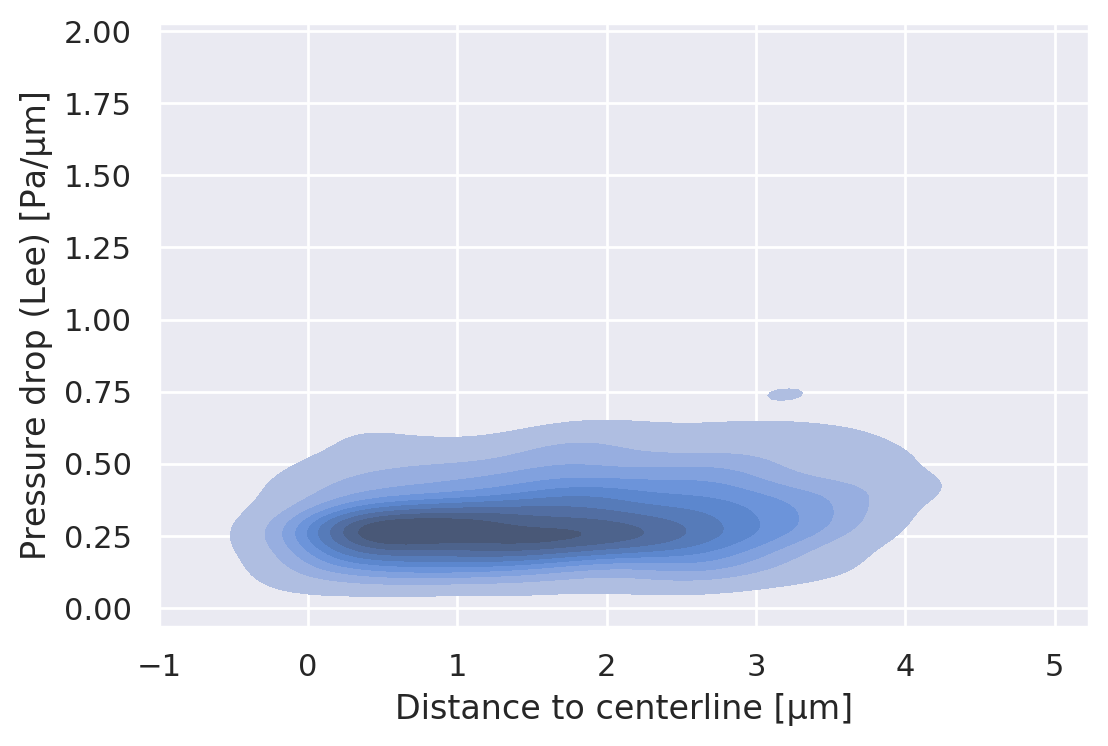

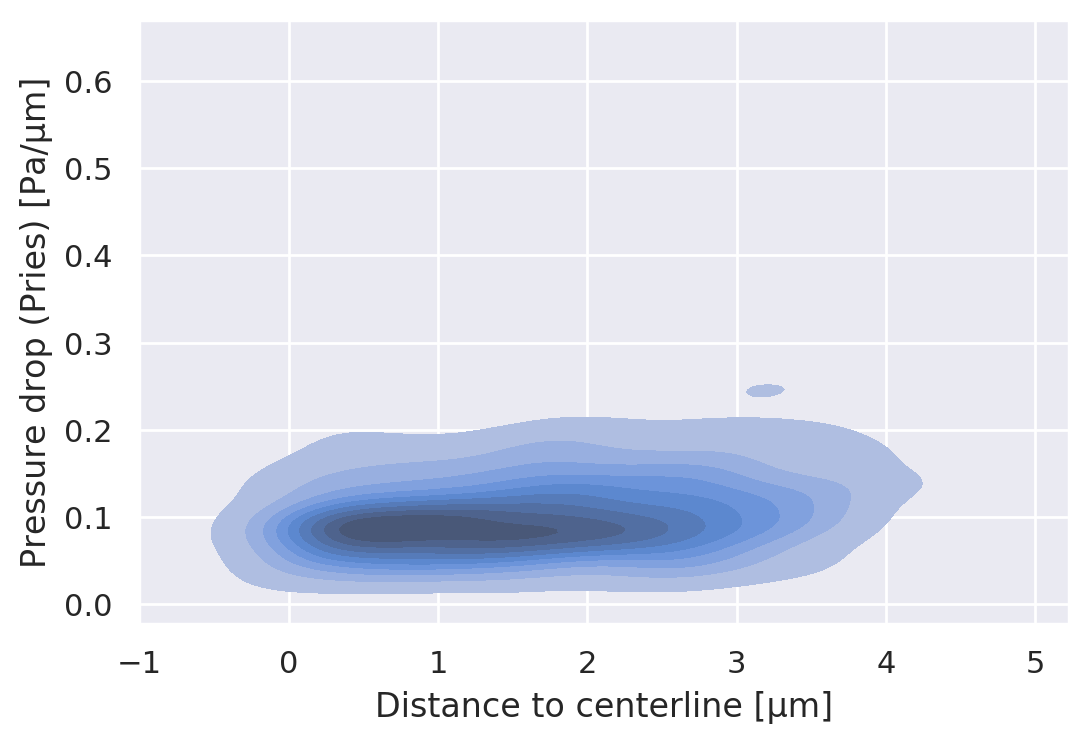

In [11]:
sns.set()
plt.figure(dpi=200)
sns.kdeplot(
    x=median_velocities["Distance to centerline [µm]"],
    y=median_velocities["Pressure drop (Lee) [Pa/µm]"],
    fill=True
)

plt.figure(dpi=200)
sns.kdeplot(
    x=median_velocities["Distance to centerline [µm]"],
    y=median_velocities["Pressure drop (Pries) [Pa/µm]"],
    fill=True
)

### Computing pressure via integral of parabola

In [12]:
def sse(a_, z, v):
    return 0.5*((a_*z - v)**2).sum()

def sse_diff(a_, z, v):
    return (a_*z - v).sum()


data = []
for (dataset_id, roi_id), df in median_velocities.groupby(["dataset_id", "ROI ID"]):
    R = df["Max R [µm]"].unique().item()
    v = df["v [µm/s]"]
    n = 2
    normalised_distances = df["Distance to centerline [µm]"]/ R
    z = 1 - normalised_distances**n

    ## Fit amplitude of velocity profile
    a_min = 0
    grad_min = sse_diff(a_min, z, v)
    a_max = 10*df['v [µm/s]'].max()
    grad_max = sse_diff(a_max, z, v)
    a__µm_per_s = brentq(lambda x: sse_diff(x, z, v), a_min, a_max)

    auto_velocities["Pressure drop (integral based) (Lee) [Pa/µm]"] = (
        a__µm_per_s * (4 * Lee_viscosity__Pa_s) / (R**2)
    )
    auto_velocities["Pressure drop (integral based) (Pries) [Pa/µm]"] = (
        a__µm_per_s * (4 * Pries_viscosity__Pa_s(R)) / (R**2)
    )
    
    
    data.append({
        'dataset_id': dataset_id,
        'ROI ID': roi_id,
        'Pressure drop (integral based) (Lee) [Pa/µm]': a__µm_per_s * (4 * Lee_viscosity__Pa_s) / (R**2),
        'Pressure drop (integral based) (Pries) [Pa/µm]': a__µm_per_s * (4 * Pries_viscosity__Pa_s(R)) / (R**2),
        'Name': auto_velocities[(auto_velocities["dataset_id"] == dataset_id) & (auto_velocities["ROI ID"] == roi_id)]["filename"].unique().item()
    })
integral_pressure = pd.DataFrame(data).set_index(["dataset_id", "ROI ID"])

In [13]:
grouped_medians = median_velocities.groupby(["dataset_id", "ROI ID"]).median().join(integral_pressure)
grouped_medians.to_csv(image_parent / "median_results.csv")
median_velocities.to_csv(image_parent / "per_particle_results.csv")

In [14]:
grouped_medians[[
    "vx [µm/s]",
    "vy [µm/s]",
    "v [µm/s]",
    "Distance to centerline [µm]",
    "Pressure drop (Lee) [Pa/µm]",
    "Pressure drop (Pries) [Pa/µm]",
    "Pressure drop (integral based) (Lee) [Pa/µm]",
    "Pressure drop (integral based) (Pries) [Pa/µm]",
    "Name"
]]

vx [µm/s]   vy [µm/s]    v [µm/s]  \
dataset_id ROI ID                                       
0          0      -322.718397 -292.425856  459.214042   
           1      -243.202354  105.558112  267.369246   
           2      -199.097967  -65.375323  218.063134   
1          0      -291.287477 -234.074341  392.316782   
           1      -291.296305  118.054277  337.300058   
           2      -226.640169  -86.811512  242.686878   

                   Distance to centerline [µm]  Pressure drop (Lee) [Pa/µm]  \
dataset_id ROI ID                                                             
0          0                          1.959849                     0.375822   
           1                          1.838548                     0.250965   
           2                          1.176272                     0.232624   
1          0                          1.839205                     0.343998   
           1                          1.687417                     0.298260   
           2                          1.405582                     0.261225   

                   Pressure drop (Pries) [Pa/µm]  \
dataset_id ROI ID                                  
0          0                            0.124247   
           1                            0.082886   
           2                            0.074114   
1          0                            0.113726   
           1                            0.098506   
           2                            0.083226   

                   Pressure drop (integral based) (Lee) [Pa/µm]  \
dataset_id ROI ID                                                 
0          0                                           0.394080   
           1                                           0.253040   
           2                                           0.226256   
1          0                                           0.358055   
           1                                           0.306209   
           2                                           0.283966   

                   Pressure drop (integral based) (Pries) [Pa/µm]  \
dataset_id ROI ID                                                   
0          0                                             0.130283   
           1                                             0.083571   
           2                                             0.072085   
1          0                                             0.118374   
           1                                             0.101131   
           2                                             0.090471   

                                                                Name  
dataset_id ROI ID                                                     
0          0       fast_2020-09-02_Federico t red ch_10.57.06_JFM...  
           1       fast_2020-09-02_Federico t red ch_10.57.06_JFM...  
           2       fast_2020-09-02_Federico t red ch_10.57.06_JFM...  
1          0       fast_2020-09-02_Federico t red ch_10.58.48_JFM...  
           1       fast_2020-09-02_Federico t red ch_10.58.48_JFM...  
           2       fast_2020-09-02_Federico t red ch_10.58.48_JFM...